## Neural Networks and Deep Learning
***
**Second Homework by Luca Negri, Physics of Data**

# Homework 2: Unsupervised Deep Learning: Autoencoders

## Introduction

The scope of this homework is to create a functional Autoencoder and to explore its latent space. 

Autoencoders are a type of unsupervised learning framework. Their arcitecture is comprised of two main components:

+ An **Encoder**, a neural network that will compress the samples into a set number of features. The feature set is called **Latent space** and the hope is that this should still encapsulate all of the relevant informations about the original samples.
+ A **Decoder**, which, starting from the latent space representation, will try to decompress and reconstruct the original sample.

Autoencoders are a powerful class of unsupervised learning algorithms, since they can be really flexible and adapted to all kinds of situations. The encoder could be used as a sort of lossy compression algorithm for the original samples, but one could also create new artificial samples by setting arbitrary values for the latent variables, or implement different data manipulation tecniques such as denoising and reconstruction... the applications can be really varied and in this notebook a few of these will be explored.

The structure of this notebook goes as follows:
+ Construction and hyperparameter optimization of an Autoencoder.
+ Utilizing the latent space of the encoder for a supervised learning task.
+ Exploration of the latent space, with TSNE and look at generation of samples
+ Development of a Variational Autoencoder.

# Part 1: Basic Autoencoder

### Import of the needed modules

As we did in class, the autoencoder will be implemented using the pytorch framework. Here we import all of the needed modules.

In [239]:
#basics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#pytorch
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#Sklearn
from sklearn.model_selection import train_test_split

#others
import os
from tqdm import tqdm

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


## Dataset
As the previous homework, the samples will be taken from the FashionMNIST dataset, wich contains 28x28 single channel (black and white) images of items of clothing. These samples are from 10 different classes, wich will be used in the supervised learning task. All of the imaes are in a PIL format.

Here are a few examples of the different images.

In [240]:
total_dataset = torchvision.datasets.FashionMNIST('../classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('../classifier_data', train=False, download=True)

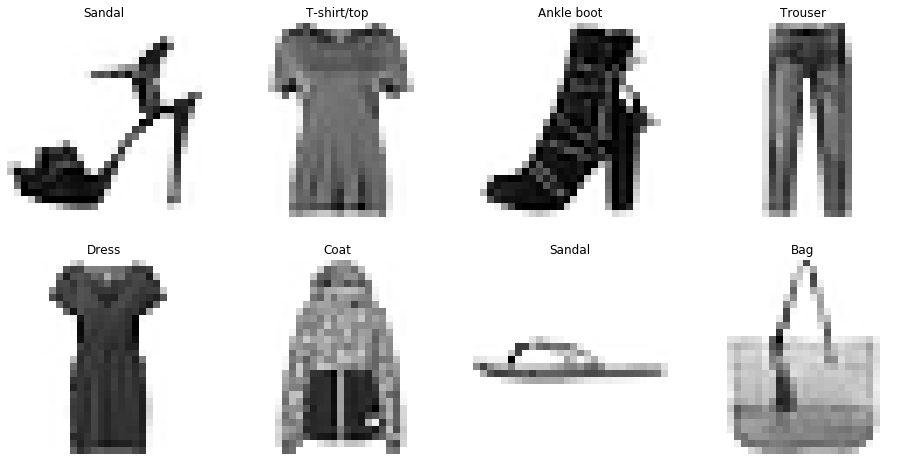

In [241]:
classes = total_dataset.classes
fig = plt.figure(figsize=(16,8))
for sample_index,nplot in zip([9,10,11,16,20,22,30,35],range(241,249)):
    image = total_dataset[sample_index][0]
    label = total_dataset[sample_index][1]
    fig.add_subplot(nplot)
    plt.imshow(image, cmap='Greys')#,vmax = 255)
    plt.title(classes[label])
    plt.axis('off')
plt.show()

## Transforms

The dataset needs to be a pytorch tensor in order for it to be handled by the network, so a transform needs to be defined.

A white noise tranform is also here defined that will be more useful in a later task.

In [4]:
class WhiteNoise():
    """Class aimed at transforming a dataset adding random gaussian noise to the input variables"""
    def __init__(self, mu = 0.0 , std = 1.0):
        self.mu  = mu
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mu
    
    
WNoiseTransform = WhiteNoise( std = 0.2)

train_transforms = transforms.Compose([
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

In the cell below the data will be divided into validation and training sets.As it is common with these tasks the validation set is kept at 20 % of the total data, with the split handled by the pytorch function `data.random_split`.

The data will be also prepared for training by appling the `Dataloader` function, that will automatically divide the training set in batches and randomly shuffling damples each training pass.

In [5]:
val_split = 0.2

Ntot   = len(total_dataset)
Nval   = int(Ntot * val_split)
Ntrain = Ntot - Nval

train_dataset, val_dataset = torch.utils.data.random_split(total_dataset, [Ntrain, Nval])


test_dataset.transform  = test_transforms
val_dataset.dataset.transform   = train_transforms
train_dataset.dataset.transform = train_transforms

num_workers = 0 #PC
#num_workers = 2 #####COLAB ENABLED
batch_size = 512
train_dataloader = DataLoader(train_dataset , batch_size = batch_size        , shuffle = True  , num_workers=num_workers)
val_dataloader   = DataLoader(val_dataset   , batch_size = len(val_dataset)  , shuffle = True  , num_workers=num_workers)
test_dataloader  = DataLoader(test_dataset  , batch_size = len(test_dataset) , shuffle = False , num_workers=num_workers)

## Network architecture

Since we are dealing with images, a **Convolutional Autoencoder** was the architecture of choice.

Even if it's possible to create asimmetrical networks, for this application a **Symmetrical** Encoder and decoder architecture has been chosen. So the descriptions of the two networks, even if working indipendently, are deeply related.

### Encoder
The Encoder is structured as follows:

+ An input layer from the images, wich must be 28x28 in size
+ A first convolutional layer, with $N_{ch1}$ channels and $K_1$ as the kernel size. The Final value for these  variables will be the objective of the random search. The stride is kept at 2 and padding at 1.
+ A second convolutional layer with $N_{ch2}$ which will be $2N_{ch1}$ chanels and $K_2$ as the kernel size. Again the stride is kept at 2 and the padding at 1
+ A third convolutional layer with $N_{ch3}$, wich will be $4N_{ch1}$ channles and $K_3$ as the kernel size. Stride is still at 2 but no padding is used in this last stage.
+ After flattening the channles of the third convolutional layer, the output is fed to a Fully Connected Layer with $N_h$ nodes.
+ A final output layer that directly gives out the values of the latent space representation of the sample

For all of the layers, except the last, the activation function is the standard ReLU function. The inizialization sheme chosen is the **Xavier normal**. The possibility of adding dropout to avoid overfiting is also added to the class. 


In [6]:
def init_weights(m):
    """Function to initialize weights in a layer"""
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        
        # gain is a parameter to be given to the xavier normal to decide the std, depends on the activation
        torch.nn.init.xavier_normal_(m.weight , torch.nn.init.calculate_gain( 'relu' ) )
        m.bias.data.fill_(0.01)

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, InputShape, CH1 , Ksize1 , CH2 , Ksize2 , CH3 , Ksize3,
                 FCL,  encoded_space_dim,pDropout=0.0, init_func=init_weights):
        super().__init__()
        
        ### Convolutional section
        self.EncoderCNN = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=CH1, kernel_size=Ksize1, 
                      stride=2, padding=1),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=CH1, out_channels=CH2, kernel_size=Ksize2, 
                      stride=2, padding=1),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=CH2, out_channels=CH3, kernel_size=Ksize3, 
                      stride=2, padding=0),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        # Ugly hack to calculate the shape of the output of the convolutional layer
        dummy_sample_image = torch.zeros(InputShape)
        self.FinalConvShape = self.EncoderCNN(dummy_sample_image).shape
        self.FlatConvSize  = np.prod(self.FinalConvShape)

        ### Linear section
        self.EncoderLin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=self.FlatConvSize, out_features=FCL),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=FCL, out_features=encoded_space_dim)
        )
        
        
        self.EncoderCNN.apply(init_func)
        self.EncoderLin.apply(init_func)
        
    def forward(self, x):
        # Apply convolutions
        x = self.EncoderCNN(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.EncoderLin(x)
        return x

### Decoder

The decoder has a basically completly specular structure with respect to the Encoder. 


+ An input layer that takes in the values of the latent space representating the original sample
+ A Fully Connected Layer with $N_h$ nodes.
+ A first transposed convolution, that takes as input the Deconvolved output of the FCL of $N_{ch3}$ channels and transposes it to $N_{ch2}$ channels
+ A second transposed convolution, that reduces the input to $N_{ch1}$ channels
+ A third and final transposed convolution that should give as output a 28x28 single channel image, representing the reconstruction of the original sample.

Again, as the encoder, the activation function is the ReLU, the inizialization scheme chosen is the Xavier normal, the user also has the possibility to add the dropout to facilitate training.


In [8]:
class Decoder(nn.Module):
    
    def __init__(self,FinalConvShape, CH1 , Ksize1 , CH2 , Ksize2 , CH3 , Ksize3,
                 FCL,  encoded_space_dim,pDropout=0.0, init_func=init_weights):
        super().__init__()
        
        FlatConvSize  = np.prod(FinalConvShape)

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=FCL),
            nn.ReLU(True),
            torch.nn.Dropout(pDropout),
            # Second linear layer
            nn.Linear(in_features=FCL, out_features=FlatConvSize),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=FinalConvShape)

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=CH3, out_channels=CH2, kernel_size=Ksize3, 
                               stride=2, output_padding=0),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=CH2, out_channels=CH1, kernel_size=Ksize2, 
                               stride=2, padding=1, output_padding=1),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=CH1, out_channels=1, kernel_size=Ksize1, 
                               stride=2, padding=1, output_padding=1)
        )
        
        self.decoder_conv.apply(init_func)
        self.decoder_lin.apply(init_func)
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

A trial run is performed here to see if the network is working as expected. A kernel window of 3x3 for $K_1$,$K_2$ and $K_3$. The FCL has $N_h$set to 64 nodes. $N_{ch1}$ is set to 8, and the following layers's $N_{ch2}$, $N_{ch3}$ are set to double each step.

The latent space is kept at 10 dimensions. trying somehow to capture the fact that the samples are coming from 10 different classes.

In the image below it is possible to see the decoded sample. Since the network has not yet been trained it will look totally random.

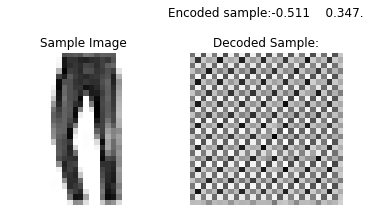

In [9]:
InputShape = (1,1,28,28)


CH1,CH2,CH3 = 8 , 16 , 32
Ksize1,Ksize2,Ksize3 = [(3,3)]*3
FCL = 64

encoded_space_dim = 10
EncoderNet = Encoder(InputShape,CH1,Ksize1,CH2,Ksize2,CH3,Ksize3,FCL,encoded_space_dim)
# Variable that tells the decoder the correct size of the last layer of the FCL part.
FinalConvShape = EncoderNet.FinalConvShape[1:]

DecoderNet = Decoder(FinalConvShape , CH1 , Ksize1 , CH2 , Ksize2 , CH3 , Ksize3 , FCL , encoded_space_dim)

image = test_dataset[5][0]
encoded_sample = EncoderNet(image.unsqueeze(0))

plt.subplot(1,2,1)
plt.title('Sample Image')
plt.imshow(image.squeeze(0) , cmap='Greys')
plt.axis('off')
plt.subplot(1,2,2)
plt.title(f'Encoded sample:{encoded_sample[0][0]:.3f}    {encoded_sample[0][1]:.3f}.\n\nDecoded Sample:' )
plt.imshow(DecoderNet(encoded_sample).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys')
plt.axis('off')
plt.show()

## Test Training

Here we define the functions needed for the training of the network.


+ `train_epoch` makes a single pass over all of the training data and updates the weights of both the encoder and the decoder trought backpropagation of the gradient over the loss funcion `loss_fn` and optimizes it with the given user defined `optimizer`.
+ `test_epoch` just evaluates the performance of the network over a specific dataset, giving as output the calculated loss.
+ `train_func` automates the train and evaluation steps for a given number of epochs, giving as output the trained network and the loss over the epochs for both the train and valdation set.




In [473]:
def train_epoch(encoder,decoder,device, dataloader, loss_fn, optimizer,transform = None, unsupervised = True, verbose=0, disable_tqdm=True):
    """Function to advance training one step"""
    # Set train mode
    encoder.train()
    decoder.train()
    for train_batch, label_batch in tqdm(dataloader,position=0,leave=True,disable=disable_tqdm):
        # Move tensors to the selected device
        train_batch = train_batch.to(device)
        label_batch = label_batch.to(device)
        # Forward pass
        if unsupervised:
            label_batch = train_batch
        if transform is not None:
            train_batch = transform(train_batch)
        latentvar = encoder(train_batch)
        out       = decoder(latentvar)
        # Evaluate loss
        loss = loss_fn(out, label_batch)
        # Backward pass and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print loss
        if verbose==2:
            print('\t Training loss (single batch):', float(loss.data))
            
            
### Testing function
def test_epoch(encoder,decoder, device, dataloader, loss_fn ,transform = None,unsupervised = True,kl = 0,disable_tqdm=True):
    # Set evaluation mode
    encoder.eval()
    decoder.eval
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for train_batch, label_batch in tqdm(dataloader,position=0,leave=True,disable=disable_tqdm):
            # Move tensor to the proper device
            train_batch = train_batch.to(device)
            label_batch = label_batch.to(device)
            # Forward pass
            if unsupervised:
                label_batch = train_batch
            if transform is not None:
                train_batch = transform(train_batch)
            
            latentvar = encoder(train_batch)
            out       = decoder(latentvar)    
            # Append the network output and the original to the lists
            conc_out.append(out)
            conc_label.append(label_batch)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return conc_out, conc_label, val_loss.data # We return all the outputs, all the labels and the global loss


def train_func(encoder,decoder, train_dataloader ,val_dataloader , device, loss_fn, optimizer,transform = None,unsupervised = True ,verbose = 1, num_epochs=50, disable_tqdm=True ):
    ### TRAINING!

    train_losses = []
    val_losses = []
    
    tqdm_upper = True
    if verbose == 0 :
        tqdm_upper = False
        
    for epoch in tqdm(range(num_epochs),position=0,leave=True,disable=tqdm_upper):
        if verbose >= 1:
            print(f"EPOCH {epoch + 1}/{num_epochs}")
        ### Training 
        train_epoch(
            encoder,decoder,
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optimizer,
            transform=transform,
            unsupervised=unsupervised,
            verbose=verbose,
            disable_tqdm=disable_tqdm)

        ### Train loss 
        _, _, train_loss = test_epoch(
            encoder, decoder,
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn,
            transform=transform,
            unsupervised=unsupervised,
            disable_tqdm=disable_tqdm)

        # Print Train loss
        if verbose >=1:
            print(f"\n\n\t TRAIN - EPOCH {epoch + 1}/{num_epochs} - train loss: {train_loss}\n\n")
        train_losses.append(train_loss)

        ### Validation 
        _, _, val_loss = test_epoch(
            encoder,decoder,
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn,
            unsupervised=unsupervised,
            disable_tqdm=disable_tqdm)

        # Print Validation loss
        if verbose>=1:
            print(f"\n\n\t VALIDATION - EPOCH {epoch + 1}/{num_epochs} - val loss: {val_loss}\n\n")
        val_losses.append(val_loss)
        
    return train_losses, val_losses

In the cell below a test training is done, with some provisional hyperparameter choice.

The loss function chosen for this task is the **Mean squared error** since it will indicate to the optimizer how distant each pixel of the decoded image is from its original sample counterpart.

In [15]:
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 2e-3 # Learning rate
params_to_optimize = [
    {'params': EncoderNet.parameters()},
    {'params': DecoderNet.parameters()}
]
optimizer = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')




Selected device: cpu


In [16]:
train_losses, val_losses = train_func(EncoderNet,DecoderNet, train_dataloader , val_dataloader,
                                     device, loss_fn, optimizer, verbose = 0,
                                      num_epochs  = 10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:20<00:00, 26.10s/it]


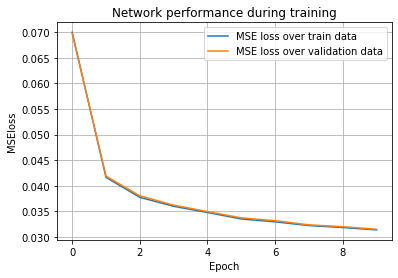

In [194]:
plt.plot(train_losses, label = 'MSE loss over train data')
plt.plot(val_losses, label = 'MSE loss over validation data')
plt.xlabel('Epoch')
plt.ylabel('MSEloss')
plt.title('Network performance during training')
plt.legend()
plt.grid()
plt.show()

## Hyperparametr optimization 
To validate the best parameters for the Autoencoder a Random seach is performed. Then in the end the network wil be finally trained with the best results coming from this search.

### Random Search

Random searches are a common tool for hyperparameters optimizaition in machine learning. They allow to not waste as much resources as gridsearches while still maintaining a good degree of good results with high dimensional searches.

The random search itself is performed by the function `RandomSearch2` and it will choose 10 random points in hyperparameter space and perform the training. To validate the results k-fold cross validation is used, where the dataset is divided into 4 parts, of these 3 will be used as training set and one as validation. Then the training is performed again, changing each time which of the 4 sets will be validation. Then the mean of the final losses is used to compare the hyperparameters results.

The hyperparameters that the search will try to optimize are:

+ $N_{ch1}$ ($N_{ch2}$ and $N_{ch3}$ will be always kept as successive doublings of $N_{ch1}$)
+ $N_h$
+ Dropout probability
+ Optimizer (between Adam or Adamax)
+ Learning rate
+ Weight decay
+ The batch size 
+ The number of epochs

The results will be recorded in the not so originally named `results` pandas dataframe

In [342]:
def RandomSearch2(params_to_choose, EncCLass,DecClass, train_dataset, transform , n_folds = 4 , n_points = 5):
    """random search"""

    Ntot = len(train_dataset)
    Nval = int(Ntot/n_folds)
    cvs = torch.utils.data.random_split(train_dataset,[Nval]*n_folds)
    result_df_columns = ['mean_loss'] + list(params_to_choose.keys()) + ['losslog_cv' + str(i) for i in range(n_folds)] 

    results = pd.DataFrame(np.zeros((n_points,len(result_df_columns))),
                           columns = result_df_columns, dtype=object)
   

    for i in range(n_points):

        params   = {}
        for param in params_to_choose.keys():
            params[param] = np.random.choice(params_to_choose[param])

            results[param][i] = params[param]

        print('ITERATION N ' + str(i+1))
        print('PARAMS:\n' )
        for value,name in zip(params.values(),params.keys()):
            print(name,'     \t :',value)

        val_cv_losses = []

        mean_loss = 0

        for j in range(n_folds):

            train_cv = cvs.copy()
            val_cv   = train_cv.pop(j)
            train_cv = torch.utils.data.ConcatDataset(train_cv)

            train_cv.transform = transform
            val_cv.transform   = transform

            batch_size = int(params['batch_size'])
            train_dataloader = DataLoader(train_cv , batch_size= batch_size , shuffle=True  , num_workers=0)
            val_dataloader   = DataLoader(val_cv   , batch_size=len(val_cv) , shuffle=False , num_workers=0)  
            
            InputShape  = (1,1,28,28)
            encoded_dim = params['encoded_dim']

            
            CH1       = params['CH1']
            CH2,CH3   = CH1*2 , CH1*4
            Ksize1,Ksize2,Ksize3     = [(params['Ksize'],params['Ksize'])]*3
            
            FCL       = params['FCL']
            init_func = params['init_func']
            p_drop    = params['p_drop']
            encoder   = EncClass(InputShape,CH1,Ksize1,CH2,Ksize2,CH3,Ksize3,
                                FCL,encoded_dim,init_func=init_func,pDropout=p_drop)
            FinalConvShape = encoder.FinalConvShape[1:]
            decoder   = DecClass(FinalConvShape,CH1,Ksize1,CH2,Ksize2,CH3,Ksize3,
                                FCL,encoded_dim,p_drop,init_func)
            
            encoder.to(device)
            decoder.to(device)

            loss_fn = params['loss_fn']

            optimizer = params['optimizer']
            
            params_to_optimize = [
                {'params': encoder.parameters()},
                {'params': decoder.parameters()}
            ]
            optimizer = optimizer(params_to_optimize,lr=params['lr'] , weight_decay = params['w_decay'] )

            _ , val_loss_log = train_func(encoder,decoder,train_dataloader,val_dataloader,device,
                                          loss_fn, optimizer, verbose=0,
                                          num_epochs = params['num_epochs'], disable_tqdm=True)

            results['losslog_cv' + str(j) ][i] = val_loss_log
            mean_loss += val_loss_log[-1]     

        results['mean_loss'][i] = mean_loss/n_folds
    return results

In [343]:
params_to_choose = {
    'encoded_dim': [10],
    'CH1'        : [4 , 8],
    'Ksize'      : [3],
    'FCL'    : [64 , 128 , 256],
    'init_func'  : [init_weights],
    'p_drop'     : [0.2 , 0.3 , 0.4],
    'loss_fn'    : [nn.MSELoss()],
    'optimizer'  : [optim.Adam , optim.Adamax ],
    'w_decay'    : [0    , 1e-5 , 1e-4],
    'lr'         : [5e-4 , 1e-3 , 2e-3],
    'batch_size' : [256  , 512  ,1024],
    'num_epochs' : [10 , 15]
}

In [322]:
Ntot = len(train_dataset)
NSmall = int(Ntot/4)
small_train_dataset , _ = torch.utils.data.random_split(train_dataset , [ NSmall , Ntot - NSmall ])

In [323]:
results = RandomSearch2(params_to_choose,Encoder,Decoder,small_train_dataset,train_transforms,n_points=10)

ITERATION N 1
PARAMS:

encoded_dim      	 : 10
CH1      	 : 4
Ksize      	 : 3
FCL      	 : 128
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.4
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 0.0
lr      	 : 0.001
batch_size      	 : 1024
num_epochs      	 : 15


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:06<00:00,  4.44s/it]


ITERATION N 2
PARAMS:

encoded_dim      	 : 10
CH1      	 : 8
Ksize      	 : 3
FCL      	 : 64
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.2
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
w_decay      	 : 0.0
lr      	 : 0.002
batch_size      	 : 256
num_epochs      	 : 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.20s/it]


ITERATION N 3
PARAMS:

encoded_dim      	 : 10
CH1      	 : 4
Ksize      	 : 3
FCL      	 : 128
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.4
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
w_decay      	 : 0.0001
lr      	 : 0.0005
batch_size      	 : 256
num_epochs      	 : 15


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:02<00:00,  4.17s/it]


ITERATION N 4
PARAMS:

encoded_dim      	 : 10
CH1      	 : 8
Ksize      	 : 3
FCL      	 : 256
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.4
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 0.0001
lr      	 : 0.0005
batch_size      	 : 256
num_epochs      	 : 15


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.80s/it]


ITERATION N 5
PARAMS:

encoded_dim      	 : 10
CH1      	 : 8
Ksize      	 : 3
FCL      	 : 64
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.3
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 0.0001
lr      	 : 0.002
batch_size      	 : 512
num_epochs      	 : 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.79s/it]


ITERATION N 6
PARAMS:

encoded_dim      	 : 10
CH1      	 : 8
Ksize      	 : 3
FCL      	 : 64
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.4
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 0.0001
lr      	 : 0.001
batch_size      	 : 512
num_epochs      	 : 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.51s/it]


ITERATION N 7
PARAMS:

encoded_dim      	 : 10
CH1      	 : 4
Ksize      	 : 3
FCL      	 : 128
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.2
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 0.0001
lr      	 : 0.002
batch_size      	 : 512
num_epochs      	 : 15


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:05<00:00,  4.34s/it]


ITERATION N 8
PARAMS:

encoded_dim      	 : 10
CH1      	 : 4
Ksize      	 : 3
FCL      	 : 128
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.2
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 1e-05
lr      	 : 0.0005
batch_size      	 : 256
num_epochs      	 : 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.46s/it]


ITERATION N 9
PARAMS:

encoded_dim      	 : 10
CH1      	 : 4
Ksize      	 : 3
FCL      	 : 128
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.4
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 0.0
lr      	 : 0.002
batch_size      	 : 512
num_epochs      	 : 15


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:08<00:00,  4.55s/it]


ITERATION N 10
PARAMS:

encoded_dim      	 : 10
CH1      	 : 4
Ksize      	 : 3
FCL      	 : 128
init_func      	 : <function init_weights at 0x00000182C5771C80>
p_drop      	 : 0.4
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
w_decay      	 : 1e-05
lr      	 : 0.002
batch_size      	 : 1024
num_epochs      	 : 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.65s/it]


In [324]:
results

,mean_loss,encoded_dim,CH1,Ksize,FCL,init_func,p_drop,loss_fn,optimizer,w_decay,lr,batch_size,num_epochs,losslog_cv0,losslog_cv1,losslog_cv2,losslog_cv3
0,tensor(0.0858),10,4,3,128,<function init_weights at 0x00000182C5771C80>,0.4,MSELoss(),<class 'torch.optim.adam.Adam'>,0,0.001,1024,15,"[tensor(0.1445), tensor(0.1404), tensor(0.1345...","[tensor(0.1731), tensor(0.1639), tensor(0.1529...","[tensor(0.1429), tensor(0.1408), tensor(0.1364...","[tensor(0.1476), tensor(0.1467), tensor(0.1458..."
1,tensor(0.0489),10,8,3,64,<function init_weights at 0x00000182C5771C80>,0.2,MSELoss(),<class 'torch.optim.adamax.Adamax'>,0,0.002,256,10,"[tensor(0.1305), tensor(0.1028), tensor(0.0752...","[tensor(0.1245), tensor(0.0927), tensor(0.0734...","[tensor(0.1481), tensor(0.1037), tensor(0.0900...","[tensor(0.1313), tensor(0.0966), tensor(0.0765..."
2,tensor(0.1024),10,4,3,128,<function init_weights at 0x00000182C5771C80>,0.4,MSELoss(),<class 'torch.optim.adamax.Adamax'>,0.0001,0.0005,256,15,"[tensor(0.1659), tensor(0.1625), tensor(0.1565...","[tensor(0.1424), tensor(0.1387), tensor(0.1330...","[tensor(0.1786), tensor(0.1757), tensor(0.1722...","[tensor(0.1674), tensor(0.1642), tensor(0.1607..."
3,tensor(0.0548),10,8,3,256,<function init_weights at 0x00000182C5771C80>,0.4,MSELoss(),<class 'torch.optim.adam.Adam'>,0.0001,0.0005,256,15,"[tensor(0.2107), tensor(0.1979), tensor(0.1647...","[tensor(0.1795), tensor(0.1534), tensor(0.1279...","[tensor(0.1862), tensor(0.1333), tensor(0.1106...","[tensor(0.1556), tensor(0.1182), tensor(0.1035..."
4,tensor(0.0518),10,8,3,64,<function init_weights at 0x00000182C5771C80>,0.3,MSELoss(),<class 'torch.optim.adam.Adam'>,0.0001,0.002,512,10,"[tensor(0.1364), tensor(0.1036), tensor(0.0926...","[tensor(0.1349), tensor(0.1097), tensor(0.0963...","[tensor(0.1702), tensor(0.1112), tensor(0.0950...","[tensor(0.1463), tensor(0.1019), tensor(0.0926..."
5,tensor(0.0720),10,8,3,64,<function init_weights at 0x00000182C5771C80>,0.4,MSELoss(),<class 'torch.optim.adam.Adam'>,0.0001,0.001,512,10,"[tensor(0.1511), tensor(0.1480), tensor(0.1364...","[tensor(0.1396), tensor(0.1323), tensor(0.1134...","[tensor(0.1458), tensor(0.1421), tensor(0.1251...","[tensor(0.1685), tensor(0.1309), tensor(0.1078..."
6,tensor(0.0532),10,4,3,128,<function init_weights at 0x00000182C5771C80>,0.2,MSELoss(),<class 'torch.optim.adam.Adam'>,0.0001,0.002,512,15,"[tensor(0.1671), tensor(0.1621), tensor(0.1536...","[tensor(0.1844), tensor(0.1709), tensor(0.1236...","[tensor(0.1451), tensor(0.1376), tensor(0.1078...","[tensor(0.1580), tensor(0.1548), tensor(0.1492..."
7,tensor(0.0721),10,4,3,128,<function init_weights at 0x00000182C5771C80>,0.2,MSELoss(),<class 'torch.optim.adam.Adam'>,1e-05,0.0005,256,10,"[tensor(0.1515), tensor(0.1258), tensor(0.1072...","[tensor(0.1813), tensor(0.1790), tensor(0.1765...","[tensor(0.2076), tensor(0.1788), tensor(0.1372...","[tensor(0.1934), tensor(0.1900), tensor(0.1872..."
8,tensor(0.0699),10,4,3,128,<function init_weights at 0x00000182C5771C80>,0.4,MSELoss(),<class 'torch.optim.adam.Adam'>,0,0.002,512,15,"[tensor(0.1420), tensor(0.1111), tensor(0.0975...","[tensor(0.1391), tensor(0.1130), tensor(0.1031...","[tensor(0.1303), tensor(0.1100), tensor(0.0951...","[tensor(0.1558), tensor(0.1489), tensor(0.1398..."
9,tensor(0.1115),10,4,3,128,<function init_weights at 0x00000182C5771C80>,0.4,MSELoss(),<class 'torch.optim.adamax.Adamax'>,1e-05,0.002,1024,10,"[tensor(0.1423), tensor(0.1372), tensor(0.1320...","[tensor(0.1479), tensor(0.1464), tensor(0.1449...","[tensor(0.1679), tensor(0.1636), tensor(0.1580...","[tensor(0.1788), tensor(0.1604), tensor(0.1441..."


## Training with the best results of the random search

Here the best results coming out of the random search are presented. As we can see a value of 8 is chosen for $N_{ch1}$ a value of 64 is chosen for $N_h$. Dropout is kept at 0.2, learning rate at 2e-3, batch size of 256 and no weight decay.

In [326]:
best_results = results.loc[results.mean_loss.apply(float).idxmin()]
best_results

mean_loss                                         tensor(0.0489)
encoded_dim                                                   10
CH1                                                            8
Ksize                                                          3
FCL                                                           64
init_func          <function init_weights at 0x00000182C5771C80>
p_drop                                                       0.2
loss_fn                                                MSELoss()
optimizer                    <class 'torch.optim.adamax.Adamax'>
w_decay                                                        0
lr                                                         0.002
batch_size                                                   256
num_epochs                                                    10
losslog_cv0    [tensor(0.1305), tensor(0.1028), tensor(0.0752...
losslog_cv1    [tensor(0.1245), tensor(0.0927), tensor(0.0734...
losslog_cv2    [tensor(0.

In [369]:
batch_size = best_results.batch_size
train_dataloader = DataLoader(train_dataset , batch_size=int(batch_size)  , shuffle=True  , num_workers=0)
val_dataloader   = DataLoader(val_dataset   , batch_size=len(val_dataset) , shuffle=False , num_workers=0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


torch.manual_seed(0)
Input_shape = (28,28)
encoded_dim = 10
CH1         = best_results.CH1
CH2,CH3     = CH1*2 , CH1*4
Ksize1,Ksize2,Ksize3     = [(3,3)]*3
FCL   = best_results.FCL

EncoderNet = Encoder(InputShape,CH1,Ksize1,CH2,Ksize2,CH3,Ksize3,FCL,encoded_dim)
FinalConvShape = EncoderNet.FinalConvShape[1:]
DecoderNet = Decoder(FinalConvShape , CH1 , Ksize1 , CH2 , Ksize2 , CH3 , Ksize3 , FCL , encoded_dim)


params_to_optimize = [
    {'params': EncoderNet.parameters()},
    {'params': DecoderNet.parameters()}
]


optimizer = best_results.optimizer(params_to_optimize, lr=best_results.lr
                                   ,weight_decay=best_results.w_decay)
loss_fn = nn.MSELoss()

train_losses, val_losses = train_func(EncoderNet,DecoderNet, train_dataloader , val_dataloader,
                                     device, loss_fn, optimizer, verbose = 0,
                                      num_epochs  = best_results.num_epochs)

Training device: cpu


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:06<00:00, 24.70s/it]


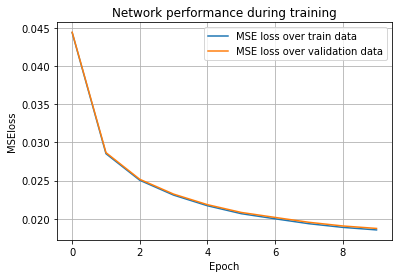

In [372]:
plt.plot(train_losses, label = 'MSE loss over train data')
plt.plot(val_losses, label = 'MSE loss over validation data')
plt.xlabel('Epoch')
plt.ylabel('MSEloss')
plt.title('Network performance during training')
plt.legend()
plt.grid()
plt.show()

As we can see the training goes on pretty smoothly, with the reconstruction loss of the training set kept basically equal to the validation set, meaning that overefitting does not play a role in the network training.

In [418]:
torch.save(EncoderNet.state_dict(), 'encoder_params.pth')
torch.save(DecoderNet.state_dict(), 'decoder_params.pth')

## Test the performance of the network

Our next step is to visually inspect the performance of the network, in particular now the objective is to focus on how many features and how accuratly the decoded samples reconstruct their original counterparts.

In [470]:
EncoderNet.load_state_dict(torch.load('encoder_params.pth'))
DecoderNet.load_state_dict(torch.load('decoder_params.pth'))

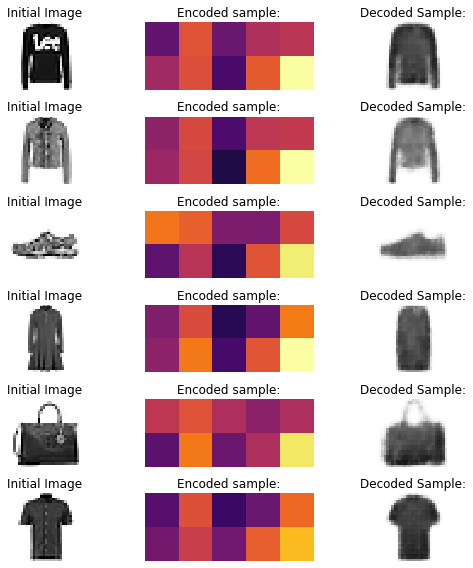

In [27]:
sample_idxs = [1,10,21,29,30,40]
plt.figure(figsize=[8,8])
n  = len(sample_idxs)

EncoderNet.eval()
DecoderNet.eval()
with torch.no_grad():
    for i,idx in enumerate(sample_idxs):

        image = test_dataset[idx][0]
        encoded_sample = EncoderNet(image.unsqueeze(0))

        plt.subplot(n,3,1+ i*3)
        plt.title('Initial Image')
        plt.imshow(image.squeeze(0) , cmap='Greys',vmin=0,vmax=1)
        plt.axis('off')

        plt.subplot(n,3,2+i*3)
        plt.title(f'Encoded sample:')
        plt.imshow(encoded_sample.detach().numpy().reshape(2,5) , cmap='inferno',vmin = -80,vmax=+80)
        #plt.imshow(encoded_sample.detach().numpy().reshape(2,5) , cmap='Greys')#,vmin = -34,vmax=+34)
        plt.axis('off')

        plt.subplot(n,3,3+i*3)
        plt.title('Decoded Sample:' )
        plt.imshow(DecoderNet(encoded_sample).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys',vmin = 0,vmax = 1)
        plt.axis('off')
plt.tight_layout()
plt.show()

The main morphology of the samples is maintained in all of the tests here performed. In particular the main features that  make it possible to distinguish between the different classes of clothing are maintained, with maybe an exception for the dress, where the sleeves are totally removed. Of course all of the details of the clothing get lost in the compression, making them appea quite blurry. Other fine details, like the bag handle, or the sole of the shoe do not get reconstructed correctly.

### Image Denoising

Now the aim is to test some of the possible applications of such architectures. One example is the **Denoising** task, where white noise is added to the image and the machine will try to ignore it and reconstruct the original sample. The network will not be retrained for this task and we will see if it is still able to accomplish this goal.

The noise added to the images will have standard deviation equal to 0.4. given that the pixel values range between 0 and 1 this level of noise should make the images barely recognizable to human observers.

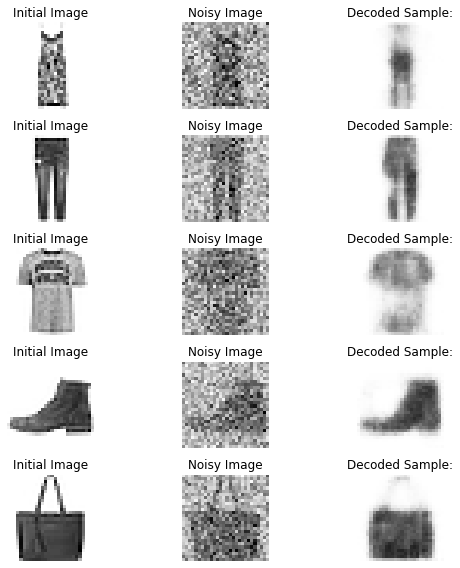

In [238]:
noise_func = WhiteNoise( std = 0.4)
sample_idxs = [300,200,201,208,900]
n  = len(sample_idxs)
plt.figure(figsize=[8,8])


EncoderNet.eval()
DecoderNet.eval()
with torch.no_grad():

    for i,idx in enumerate(sample_idxs):

        image = test_dataset[idx][0]
        noisy_sample = noise_func(image)
        encoded_sample = EncoderNet(noisy_sample.unsqueeze(0))



        plt.subplot(n,3,1+ i*3)
        plt.title('Initial Image')
        plt.imshow(image.squeeze(0) , cmap='Greys',vmin=0,vmax=1)
        plt.axis('off')

        plt.subplot(n,3,2+i*3)
        plt.title('Noisy Image')
        plt.imshow(noisy_sample.squeeze(0) , cmap='Greys')
        plt.axis('off')

        plt.subplot(n,3,3+i*3)
        plt.title('Decoded Sample:' )
        plt.imshow(DecoderNet(encoded_sample).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys',vmin=0,vmax=1)
        plt.axis('off')
    plt.tight_layout()
    plt.show()



As we can see, even with a bit of difficulty, the network is able to retrive the most important informations about the samples,reconstructing all of the fundamental features, and removing all of the noise. 
This is accomplished even when the noise level is such that even human observers can have difficulty in interpeting the samples.

Still the samples sometimes appear a bit deformed from their originals, so improvements could be possible.

### Image reconstruction

Now the aim is to see if the network is capable of recontructing images when pieces of them are missing. This will be obtained by placing a white square at the centre of the image, 7 pixel across, and see if the network can predicted what is underneath. 

Again, as it was with the previous task, the network is still the same as the previous tasks, it has not been retrained with this task in mind. The idea is that, sicne the network has never seen samples with white squares in the centre, it should be able to "ignore" this novel features and retrace the samples back to what they where originally. Of course a retrained network specifically with this task in mind would perform much better, but it still interesting what the network is capable of doing in its current state.

In [230]:
class WhiteBlock():
    """Class aimed at transforming a dataset adding random gaussian noise to the input variables"""
    def __init__(self, mask_size = 7):
        self.mask_size  = mask_size
    def __call__(self, tensor):
        
        shape = tensor.shape
        for i in range(shape[0]):
            mask_center = torch.randint(low=4,high=16,size=(2,1))        
            mask = torch.ones_like(image)
            mask[0,mask_center[0]:(mask_center[0])+self.mask_size , mask_center[1]:(mask_center[1])+self.mask_size] = 0
            tensor[i] = tensor[i]*mask
        
        return tensor
    

In [231]:
WhiteBlockTransform = WhiteBlock()
train_transforms = transforms.Compose([
    transforms.ToTensor(),
])

val_split = 0.2

Ntot   = len(total_dataset)
Nval   = int(Ntot * val_split)
Ntrain = Ntot - Nval

train_dataset, val_dataset = torch.utils.data.random_split(total_dataset, [Ntrain, Nval])


test_dataset.transform  = test_transforms
val_dataset.dataset.transform   = train_transforms
train_dataset.dataset.transform = train_transforms

num_workers = 0 #PC
#num_workers = 2 #####COLAB ENABLED
batch_size = 512
train_dataloader = DataLoader(train_dataset , batch_size = batch_size        , shuffle = True  , num_workers=num_workers)
val_dataloader   = DataLoader(val_dataset   , batch_size = len(val_dataset)  , shuffle = True  , num_workers=num_workers)
test_dataloader  = DataLoader(test_dataset  , batch_size = len(test_dataset) , shuffle = False , num_workers=num_workers)



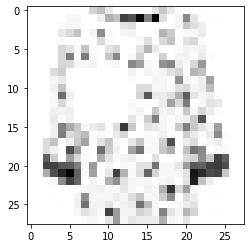

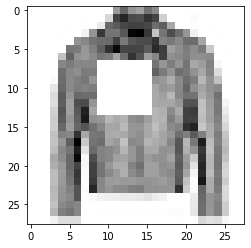

In [232]:
oh = WhiteBlockTransform(next(iter(train_dataloader))[0])
plt.imshow(oh[200].squeeze(0), cmap='Greys')#,vmax = 255)
plt.show()
plt.imshow(oh[201].squeeze(0), cmap='Greys')#,vmax = 255)



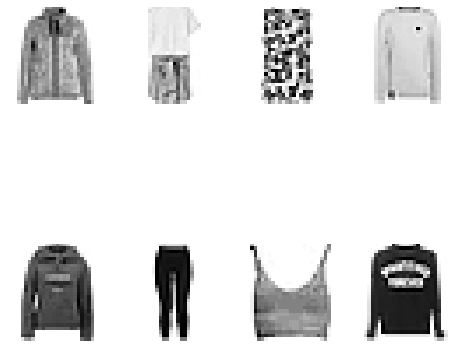

In [233]:
fig = plt.figure(figsize=[8,8])
for sample_index,nplot in zip([9,10,11,16,20,22,30,35],range(241,249)):
    image = val_dataset[sample_index][0]
    label = val_dataset[sample_index][1]
    fig.add_subplot(nplot)
    plt.imshow(image.squeeze(0), cmap='Greys')#,vmax = 255)
    plt.axis('off')
plt.show()

In [234]:
Input_shape = (28,28)
encoded_dim = 10
CH1         = 8
CH2,CH3     = CH1*2 , CH1*4
Ksize1,Ksize2,Ksize3     = [(3,3)]*3
FCL   = 128

EncoderNet = Encoder(InputShape,CH1,Ksize1,CH2,Ksize2,CH3,Ksize3,FCL,encoded_dim)
FinalConvShape = EncoderNet.FinalConvShape[1:]
DecoderNet = Decoder(FinalConvShape , CH1 , Ksize1 , CH2 , Ksize2 , CH3 , Ksize3 , FCL , encoded_dim)


params_to_optimize = [
    {'params': EncoderNet.parameters()},
    {'params': DecoderNet.parameters()}
]


optimizer = optim.Adamax(params_to_optimize, lr=1e-3
                                   ,weight_decay=1e-5)
loss_fn = nn.MSELoss()

train_losses, val_losses = train_func(EncoderNet,DecoderNet, train_dataloader , val_dataloader,
                                     device, loss_fn, optimizer,transform = WhiteBlockTransform, verbose = 0,
                                      num_epochs  = 10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:48<00:00, 28.80s/it]


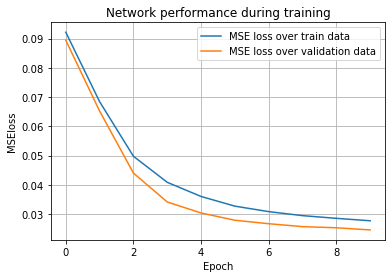

In [235]:
plt.plot(train_losses, label = 'MSE loss over train data')
plt.plot(val_losses, label = 'MSE loss over validation data')
plt.xlabel('Epoch')
plt.ylabel('MSEloss')
plt.title('Network performance during training')
plt.legend()
plt.grid()
plt.show()

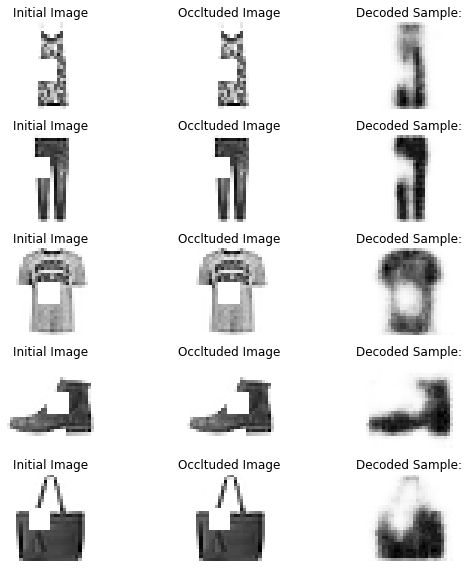

In [237]:
sample_idxs = [300,200,201,208,900]
n  = len(sample_idxs)


plt.figure(figsize=[8,8])

EncoderNet.eval()
DecoderNet.eval()
with torch.no_grad():

    for i,idx in enumerate(sample_idxs):

        image = test_dataset[idx][0]
        noisy_sample = WhiteBlockTransform( image)
        encoded_sample = EncoderNet(noisy_sample.unsqueeze(0))



        plt.subplot(n,3,1+ i*3)
        plt.title('Initial Image')
        plt.imshow(image.squeeze(0) , cmap='Greys')
        plt.axis('off')

        plt.subplot(n,3,2+i*3)
        plt.title('Occltuded Image')
        plt.imshow(noisy_sample.squeeze(0) , cmap='Greys')
        plt.axis('off')

        plt.subplot(n,3,3+i*3)
        plt.title('Decoded Sample:' )
        plt.imshow(DecoderNet(encoded_sample).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys')
        plt.axis('off')

    plt.tight_layout()    
    plt.show()

As it possible to see the network is struggling to see whats underneath the block, but it still tries whit discrete results. Maybe a smaller window would provide better results.

# Fine-tuned in supervised learning task

This task is aimed to explore the possibilities that unsupervised learning has in improving the capabilities of a supervised learning task. This will be done by training a Fully connected neural network on a classifier task using as input the Latent variables of the autoencoder. This could help in speeding up the task, reducing the size of the fully connected network stage and possibly improving its accuracy. The FCL network will have:

+ An input layer with 10 nodes, which represent the latent space size.
+ 2 hidden layers with 128 nodes each.
+ An output layer corresponding to the 10 classes of clothing to which the samples belong.

The training parameters are based on the parameters obtained in the hypersearch used in the previous homework.

In [474]:
class FCLNet(nn.Module):
    
    """Network class, contains 3 hidden layers"""
    
    def __init__(self, InputSize,  No, FCLSize = [128,128], 
                 pDropout=0.0, init_func=init_weights):
        """
        Args:
        InputSize (tuple)                 : Input size of the encoded space
        No (int)                          : Output size
        FCLSize (int)                     : Fully connected Layer Size
        pDropout (float [0,1] )           : Probability of dropout
        init_func (nn.init function)      : Function to be applied to inizialize Tensors 
        """
        super().__init__()
        
        print('Network initialized')
        
        #FC passage
        self.FCLayer = torch.nn.Sequential(
            
            torch.nn.Linear(InputSize,FCLSize[0]),
            torch.nn.Dropout(pDropout),
            torch.nn.ReLU(True),
            
            torch.nn.Linear(FCLSize[0],FCLSize[1]),
            torch.nn.Dropout(pDropout),
            torch.nn.ReLU(True),

            #Output Layer
            torch.nn.Linear(FCLSize[1],No)
            
        )
        
        #Inizialization
        self.FCLayer.apply(init_func)

        
    def forward(self, x):
        x = self.FCLayer(x)
        return x

In [475]:
No = 10
FCLSize = [128,128]
FineTuneNet = FCLNet(encoded_dim,No,FCLSize,pDropout = 0.3)

loss_fn = torch.nn.CrossEntropyLoss()
### Define an optimizer (both for the encoder and the decoder!)
lr = 2e-3 # Learning rate
optimizer = torch.optim.Adam(FineTuneNet.parameters(), lr=lr, weight_decay=1e-5)

train_losses, val_losses = train_func(EncoderNet,FineTuneNet, train_dataloader , val_dataloader,
                                     device, loss_fn, optimizer, verbose = 0,
                                      unsupervised  = False,
                                      num_epochs  =10)

Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:31<00:00, 15.19s/it]


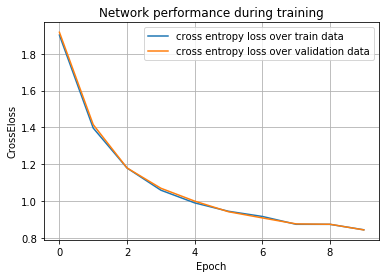

In [476]:
plt.plot(train_losses, label = 'cross entropy loss over train data')
plt.plot(val_losses, label = 'cross entropy loss over validation data')
plt.xlabel('Epoch')
plt.ylabel('CrossEloss')
plt.title('Network performance during training')
plt.legend() 
plt.grid()
plt.show()

In [428]:
sm = torch.nn.Softmax(dim=1)

val_out, val_labels , valloss = test_epoch(EncoderNet,FineTuneNet,device,test_dataloader,loss_fn,unsupervised = False)
val_out        = np.array(sm(val_out))
val_out_labels = np.argmax(val_out,axis=1)
val_acc = 100*(sum(np.array(val_labels)==val_out_labels))/val_out_labels.shape
classes = test_dataset.classes
NClass = len(classes)
Conf_matrix = np.zeros([ NClass , NClass ])
for i in np.arange(val_out_labels.size):
    Conf_matrix[ val_labels[i] , val_out_labels[i] ] += 1
_, n_of_labels = np.unique(val_labels, return_counts = True)
Conf_matrix = Conf_matrix.T/Conf_matrix.T.sum(axis=0)
Conf_matrix = Conf_matrix.T

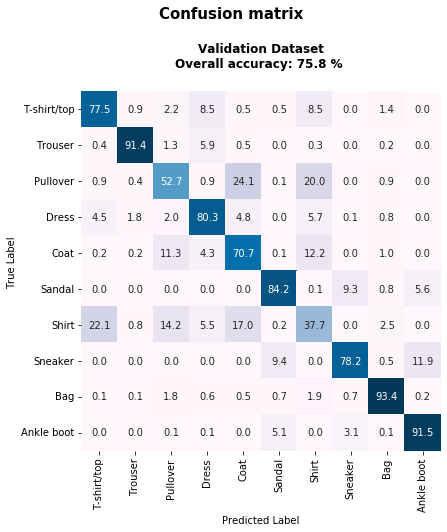

In [429]:
import seaborn as sns
fig,ax=plt.subplots(figsize=[7,7])
plt.suptitle('Confusion matrix',y=1.05,fontsize=15,weight='bold')



df_Confusion = pd.DataFrame( Conf_matrix*100 ,classes,classes)



sns.heatmap(df_Confusion, ax = ax, cmap = 'PuBu', square = True, annot = True , fmt = '.1f', 
            cbar = False, cbar_kws = {"shrink": 0.56} )

ax.set_title('Validation' + f' Dataset\nOverall accuracy: {val_acc[0]:.1f} % ', fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

ax.set_ylim(10,-0.5, -0.5)
plt.tight_layout()
#plt.savefig('net_out.png')
plt.show()

Considering that in the previous homework we got an 89% accuracy, using this method we got a measurable drop in performance, mainly due to the network consistently mistaking certain classes, like shirts and pullovers for each other. Still, considering the complexity of the task at hand it is impressive that it was able to accomplish it with just two 128 node-wide hidden layers.

The training of the task took roughtly 3 minutes, while in the previous homework it took aroud 5 minutes, so there was a noticeable improvement in learning time.

So not many improvements are seen by combining these two stages of learning. Probably increasing the size of the latent space and other improvements in the variational encoder phase could lead to improvements in the overall accuracy.



# Exploration of the Latent space
## TSNE embedding

To get a better idea of what the latent space is representing we will try to visualize the distributions of the samples in this space. Since the latent space is 10 dimensional, we need to reduce the dimensionality in order to get a human readable visualization of the latent space. A few option exixst:

+ Principal Component Analysis (PCA) projects the latent space representation in a low dimensional space, where its basis are the eigenvectors of the correlation matrix corresponding to the biggest eigenvalues. This allows to reduce the dimensionality of the samples but maximizing the remaining variance of the samples. This is a linear tranformations, so it can be limiting if the latent space has some strong non-linear behaviour.
+ T-distributed Stochastic Neighbor Embedding (TSNE) is a non-linear stochastic method of dimensionality reduction. It basically works by trying to minimize the distance of two probability distributions. One represents the probability that two points are "close" in the original high dimensional space and the other in the low dimensions.

Since it is expected that the latent space will have some non-linear behaviour, TSNE has been chosen for the 2 dimensional transofmation of our data. The perplexity parameter was chosen after a few trial runs as to better represent the distinctions between different classes of clothing.

The first step is to transfer all of the test set items in the latent space, then with the function provided by the `sklearn` library TSNE the actual embedding will be performed. After the embedding will be performed. the samples will be colored with the original class that they belonged to.

In [461]:
encoded_test  = [] # list that will contain all test samples representation in latent space
labels = []
for image,label in test_dataloader:
    encoded_test.append(EncoderNet(image))
    labels.append(label)
labels=labels[0].detach()
encoded_test = encoded_test[0].detach()

In [487]:
from sklearn.manifold import TSNE


tsne         = TSNE(n_components=2,perplexity=40)
encoded_TSNE = tsne.fit_transform(encoded_test)

In [583]:
# Saving the embedded representation of the sample. Since it is a random process different runs will give
# A different outcome, so it is better to save a specific run and do the given visualizations on it
#np.save('TSNE_embedded_encoded_FMNIST', encoded_TSNE)

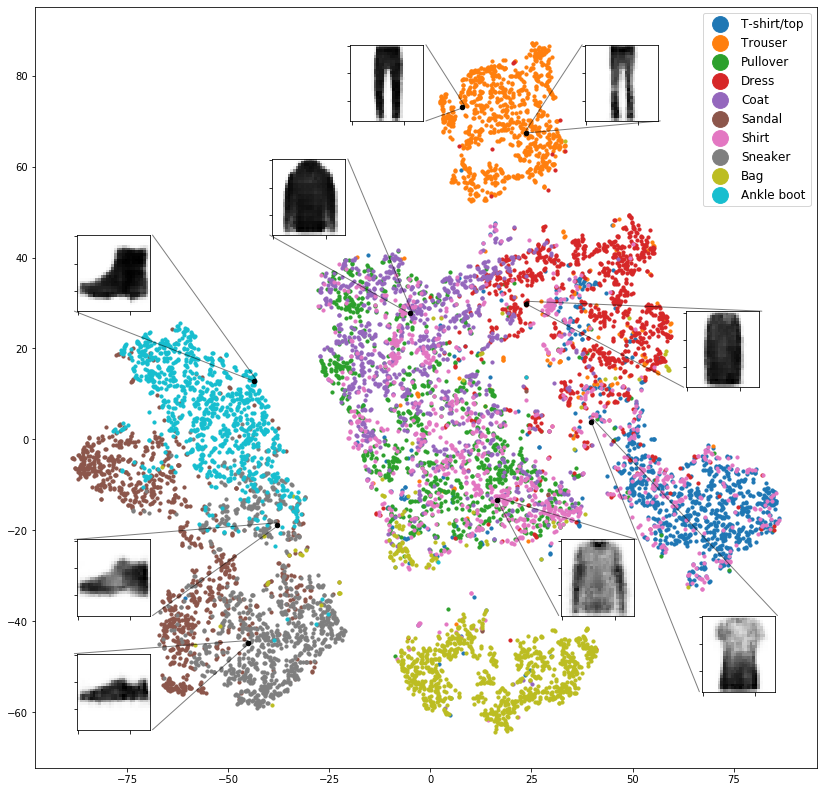

In [606]:
encoded_TSNE_loaded = np.load('TSNE_embedded_encoded_FMNIST.npy')
fig,ax = plt.subplots(figsize=[14,14])
decoded_samples = []
sample_idxs = [23,2,3,9,14,29,110,83,120]
for idx in sample_idxs:
    image = test_dataset[idx][0]
    encoded_sample = EncoderNet(image.unsqueeze(0))
    decoded_sample = DecoderNet(encoded_sample)
    decoded_samples.append(decoded_sample)

for i in range(10):
    mask = labels == i 
    ax.scatter(encoded_TSNE[mask,0],encoded_TSNE[mask,1],s=10,label=classes[i])
    
ax.legend(fontsize=12,markerscale=5)

ax.scatter(encoded_TSNE[sample_idxs,0],encoded_TSNE[sample_idxs,1],s = 20 ,c ='black')
coordsx,coordsy, thick  = [0.05 , 0.4 , 0.7 , 0.05 , 0.3 , 0.83 ,0.67, 0.05,0.85 ], [0.2,0.85,0.85,0.05,0.7,0.5,0.2,0.6,0.1],[0.1]*9
ax_inlets = [ax.inset_axes([crdsx,crdsy,thik,thik]) for crdsx,crdsy,thik in zip(coordsx,coordsy, thick)]
ax_zooms  = [ax.inset_axes([crdsx,crdsy,thik,thik]) for crdsx,crdsy,thik in zip(coordsx,coordsy, thick)]
for i,idx, ax_inlet,ax_zoom in zip(range(9),sample_idxs,ax_inlets,ax_zooms):
    x1, y1 = encoded_TSNE[idx]
    ax_zoom.set_xlim(x1, x1+0.5)
    ax_zoom.set_ylim(y1, y1+0.5)
    ax_zoom.axis('off')
    ax.indicate_inset_zoom(ax_zoom, edgecolor="black")
    ax_inlet.imshow(decoded_samples[i][0,0,:,:].detach(),cmap='Greys')
    ax_inlet.set_xticklabels([])
    ax_inlet.set_yticklabels([])
plt.show()

In the above image it is possible to see the embedding of the test set and the result of the decoding of some of the samples. It is interesting to see how the classes of clothing are clearly divided divided. The embedding can clearly distinguish between footwear, bags, trousers and shirt-like items of clothing, with these grops forming four clearly indipendent "islands". But when looking at the difference inside these macroclasses, some problems start to emerge. Shirts, pullovers and coats are all mixed together, there is also some "pollution" of shirts inside the dress and t-shirt clusters. This behaviour directly reflects the difficulties encountered by the  supervised learning task, where these items of clothing were often confised with each other. So it is sensible to assume that this is due to the limitantios of the latent space rather than of the FC neural network.

It is also interesting to note that some directions in the embedded latent space seem to encapsulate some specific features. For example it seems that in the footwear "island" the up-down direction represent how high the shoe will be, with  sneaker at the bottom and ankle boots at the top; sandals, on the other hand,  have a big variability in ankle height so they span the whole up down direction.

Another interesting feature embedded is the sleeves length that seems to be encoded in the left-right direction in the "shirts islands." with t-shirts and dresses on the rigth and pullovers all the way to the left. It is interesting to note also the low density of samples along the short-long sleeves divide, wich is to be expected since not many items of clothing with medium length sleeves exists. 

# Generation of new samples

The focus of the next section is now to try and use the latent space to generate new samples wich it has neves seen before, this could be useful in a wide host of applications, and in this notebook we will explore some of them

### Mean of each class
The aim of the first experiment is to create the latent space "ideal" for each of the classes, by finding the mean of the latent variables for each of the samples in a class, and then decoding this latent space representation to see if this ideal represent the real world.



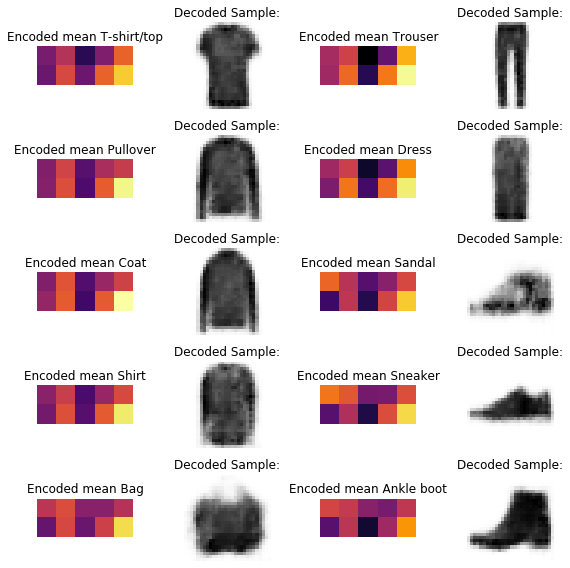

In [636]:
plt.figure(figsize=[8,8])
EncoderNet.eval()
DecoderNet.eval()
mean_objects = []
with torch.no_grad():
    for i in range(10):
        idxs = np.argwhere(labels == i).squeeze(0)
        encoded_images = []
        for idx in idxs:
            image = test_dataset[idx][0]
            encoded_images.append(EncoderNet(image.unsqueeze(0)))
        encoded_images = torch.cat(encoded_images)
        mean_image = torch.mean(encoded_images,axis=0)
        mean_objects.append(mean_image)




        plt.subplot(5,4,i*2+1)
        plt.title('Encoded mean '+classes[i])
        plt.imshow(mean_image.detach().numpy().reshape(2,5) , cmap='inferno',vmin = -80,vmax=+80)
        plt.axis('off')

        plt.subplot(5,4,i*2+2)
        plt.title('Decoded Sample:' )
        plt.imshow(DecoderNet(mean_image.unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys')
        plt.axis('off')
        
plt.tight_layout()
plt.show()

The samples seems to well represent the ideal for each class. It is interesting to look at the generated samples for the classes wich hosts the most variations (shirts, bags and sandals) that, as someone could expect, appear the most distorted.

### Randomly generated samples

Now the aim is to see if the algorithm is capable of gerating random items of clothing. This will be done by calculating the mean and standard deviation of the whole test set for each of the latent space variables and then sampling randomly in this space with a gaussian distribution. 

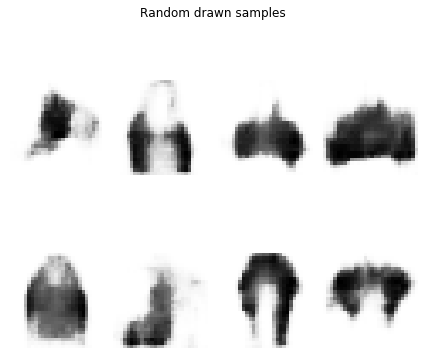

In [660]:
mean_tot = torch.mean(encoded_test,axis=0)
std_tot  = torch.std(encoded_test,axis=0) 
plt.figure(figsize=[6,6])
for i in range(8):
    latent_space = torch.normal(mean_tot,std_tot)
    plt.subplot(2,4,i+1)
    plt.imshow(DecoderNet(latent_space.unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys')
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Random drawn samples')
plt.show()

The generated items of clothing do not seem to have any of the features of usual items of clothing, so this procedure may not be suitable for the generation of credible items of clothing.

### Linear combination of samples

Another possible application of the generation of samples from the latent space is to "interpolate" between samples. By doing a linear combination of the vectors that represent these samples in latent space it is maybe possible to create a blend of two complitely different items of clothing. 

To see this process in action, the rpocess tried is to gradually increase the weight of one sample an decrease the weight of the other, as to get a somewhat smooth transition between the two.
The visualization will have on the left and on the rigth the decoded version of the original samples and in between them 9 generated images that are a linear combination of the two.


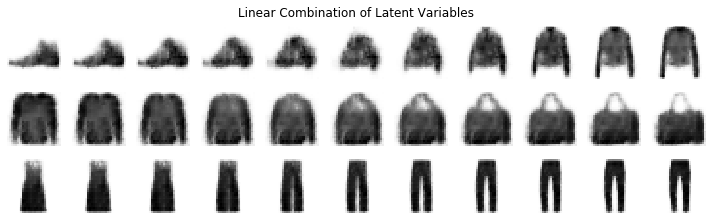

In [30]:
tot_combos  = 11
idxs = ([0,10],[20,30],[450,2])
EncoderNet.eval()
DecoderNet.eval()
plt.figure(figsize=[10,3])

with torch.no_grad():
    
    for i,idx in enumerate(idxs):
        sample1 , sample2 = test_dataset[idx[0]][0],test_dataset[idx[1]][0]
        enc1 = EncoderNet(sample1.unsqueeze(0))
        enc2 = EncoderNet(sample2.unsqueeze(0))

        ps = np.linspace(0,1,tot_combos)
        for j,p in enumerate(ps):

            lincombo = enc2*p + enc1*(1-p)
            plt.subplot(3,tot_combos,j+1+i*tot_combos)
            decod_image = DecoderNet(lincombo).squeeze(0).squeeze(0).detach()
            plt.imshow(decod_image,cmap='Greys')
            # if i==0:
            #     plt.title(f'{100-int(p*100)}% \n {int(p*100)} % ')
            plt.axis('off')
plt.suptitle('Linear Combination of Latent Variables',y=1.02)
plt.tight_layout()
plt.show()

While some of the representation in the middle, taken alone, do not seem to resemble any known item of clothing, when taken as a whole transition it has quite  a "natural" feeling, never giving out unexpected results and in the end being quite capable at blending the two images.

# Variational Autoencoder

The aim of the final task is to create a **Variational Autoencoder**. The main advantage of this arcitecture compared to the classic autoencoder is that it allows to operate and set "limitations" directly on the latent space.

In standard autoencoders the latent space can be really "chaotic". Since no restriction is applied during training, item can be mapped almost randomly in the latent space: samples that we would consider "similar" and "close toghether" may have very different representations in latent space and vice versa. Variational Autoencoder help by enforcing the "closeness" of the samples in latent space, in two main steps:
+ making the mapping **probabilistic** during the training phase, so that a sample is represented not by a point,but by a probability distribution of in latent space; The algorithm can now learn the closness of two samples by judging how much their two distributions overlap.
+ adding a regularization of latent space during training, to avoid the dispersion of samples that we get in standard autoencoders This would be the Kullbach-Liebler divergence between the standard multivariate normal distribution and the actual probability distribuiton in latent space.

The architecture of the decoder will be the same as the previous step, while the encoder will be modified so that it outputs a point sampled from a probability distribution. To accomplish this the network will have two outputs layers:
+ the $\mu$ layer will output the mean of the probability distribution associated to the sample;
+ the $\sigma$ layer will output the standard deviation of the of the probability distribution.

The distribution from which the latent space representation will be sampled will be a multivariate gaussian. To make things simple all of the off-diagonal therm of the covariance matrix will be assumed to be 0, so the $\sigma$ layer will have as many nodes as the number of latent dimensions. have. This also allows us to calculate the Kullbach-Liebler divergence between the standard gaussain $N(0,1)$ analitically, with the formula:

$D_{KL}(N(0,1)||N(\overline\mu,\overline\sigma) ) = \frac{1}{2}\sum^{n}_{i=0} (\sigma_{i}^2 + \mu_{i}^2 -1 -ln(\sigma_{i}^2))$ 

So a new class for the Variational Autoencor  need to be defined, as it is possible to see in the cell below.







In [275]:
class VariationalEncoder(nn.Module):
    
    def __init__(self, InputShape, CH1 , Ksize1 , CH2 , Ksize2 , CH3 , Ksize3,
                 FCL,  encoded_space_dim,pDropout=0.0, init_func=init_weights):
        super().__init__()
        
        ### Convolutional section
        self.EncoderCNN = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=CH1, kernel_size=Ksize1, 
                      stride=2, padding=1),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=CH1, out_channels=CH2, kernel_size=Ksize2, 
                      stride=2, padding=1),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=CH2, out_channels=CH3, kernel_size=Ksize3, 
                      stride=2, padding=0),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        # Ugly hack to calculate the shape of the output of the convolutional layer
        dummy_sample_image = torch.zeros(InputShape)
        self.FinalConvShape = self.EncoderCNN(dummy_sample_image).shape
        self.FlatConvSize  = np.prod(self.FinalConvShape)

        ### Linear section
        self.EncoderLin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=self.FlatConvSize, out_features=FCL),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),
        )
        
        # Final Layers
        self.Encodermu  = nn.Linear(in_features=FCL, out_features=encoded_space_dim)
        self.Encoderstd = nn.Linear(in_features=FCL, out_features=encoded_space_dim)

        
        self.EncoderCNN.apply(init_func)
        self.EncoderLin.apply(init_func)
        self.Encodermu.apply(init_func)
        self.Encoderstd.apply(init_func)
        
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0

        
    def forward(self, x):
        # Apply convolutions
        x = self.EncoderCNN(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.EncoderLin(x)
        
        mu  = self.Encodermu(x)
        std = torch.exp(self.Encoderstd(x))
        
        z = mu + std * self.N.sample(mu.shape)
        self.kl = (std.pow(2) + mu.pow(2) - torch.log(std) - 0.5).sum()
        
        return z if self.training else mu

Before the training a final step must be specified. For the KL regularization therm and the MSE loss to be of comparable sizes we take the sum of the MSE loss over the batch and not the mean, as it is usually the case. So new training and testing classes are modified to ease this task, for visulaization porpouses the loss per item is shown in the loss plot

In [290]:
def train_epoch(encoder, decoder,device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = encoder(x)
        x_hat = decoder(x_hat)
        # Evaluate loss
        loss = (( x - x_hat )**2).sum() + encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

def test_epoch(encoder,decoder, device, dataloader):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            x_hat = encoder(x)
            # Decode data
            x_hat = decoder(x_hat)
            loss = (( x - x_hat )**2).sum() + encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)


def train_func(encoder,decoder,train_dataloader, val_dataloader,device,optimizer,num_epochs=10,verbose = 0):
    
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(num_epochs),position=0,leave=True):
        if verbose >= 1:
            print(f"EPOCH {epoch + 1}/{num_epochs}")
        ### Training 
        train_loss = train_epoch(
            encoder,decoder,
            device=device, 
            dataloader=train_dataloader, 
            optimizer=optimizer)


        # Print Train loss
        if verbose >=1:
            print(f"\n\n\t TRAIN - EPOCH {epoch + 1}/{num_epochs} - train loss: {train_loss}\n\n")
        train_losses.append(train_loss)

        ### Validation 
        val_loss = test_epoch(
            encoder,decoder,
            device=device, 
            dataloader=val_dataloader)

        # Print Validation loss
        if verbose>=1:
            print(f"\n\n\t VALIDATION - EPOCH {epoch + 1}/{num_epochs} - val loss: {val_loss}\n\n")
        val_losses.append(val_loss)
        
    return train_losses, val_losses

For the parameters of the network we use the best results got from the previous steps. 

In [291]:
batch_size = 512
train_dataset.dataset.transform = train_transforms
train_dataloader = DataLoader(train_dataset , batch_size=int(batch_size)  , shuffle=True  , num_workers=0)
val_dataloader   = DataLoader(val_dataset   , batch_size=len(val_dataset) , shuffle=False , num_workers=0)

encoded_dim = 10

FCL = 128

CH1 = 8
CH2,CH3 = CH1*2,CH1*4
Ksize1,Ksize2,Ksize3 = 3,3,3

varencoder = VariationalEncoder(InputShape,CH1,Ksize1,CH2,Ksize2,CH3,Ksize3,FCL,encoded_dim)
FinalConvShape = varencoder.FinalConvShape[1:]
decoder    = Decoder(FinalConvShape,CH1,Ksize1,CH2,Ksize2,CH3,Ksize3,FCL,encoded_dim)

params_to_optimize = [
    {'params': varencoder.parameters()},
    {'params': decoder.parameters()}
]


optimizer = optim.Adam(params_to_optimize, lr=1e-3,weight_decay = 1e-5)

train_losses, val_losses = train_func(varencoder,decoder, train_dataloader , val_dataloader,
                                     device, optimizer, verbose = 0, num_epochs  = 10)



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:46<00:00, 16.69s/it]


In [286]:
FinalConvShape

torch.Size([32, 3, 3])

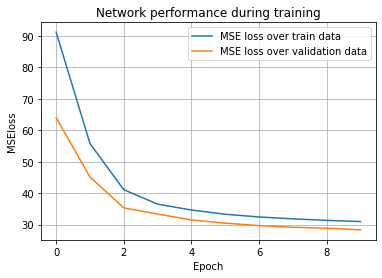

In [292]:
plt.plot(train_losses, label = 'MSE loss over train data')
plt.plot(val_losses, label = 'MSE loss over validation data')
plt.xlabel('Epoch')
plt.ylabel('MSEloss')
plt.title('Network performance during training')
plt.legend()
plt.grid()
plt.show()

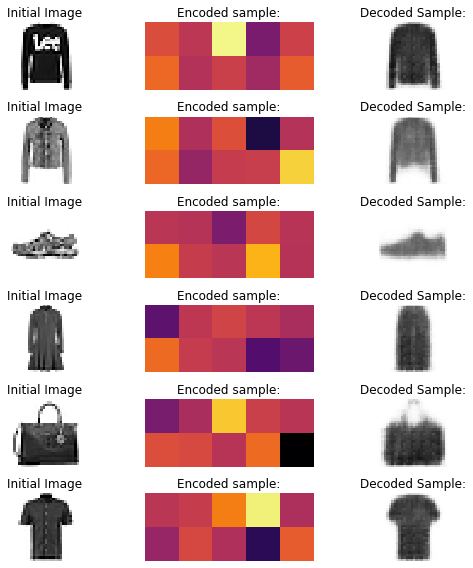

In [336]:
sample_idxs = [1,10,21,29,30,40]
plt.figure(figsize=[8,8])
n  = len(sample_idxs)

varencoder.eval()
decoder.eval()
with torch.no_grad():
    for i,idx in enumerate(sample_idxs):

        image = test_dataset[idx][0]
        encoded_sample = varencoder(image.unsqueeze(0))

        plt.subplot(n,3,1+ i*3)
        plt.title('Initial Image')
        plt.imshow(image.squeeze(0) , cmap='Greys',vmin=0,vmax=1)
        plt.axis('off')

        plt.subplot(n,3,2+i*3)
        plt.title(f'Encoded sample:')
        plt.imshow(encoded_sample.detach().numpy().reshape(2,5) , cmap='inferno',vmin = -1.5,vmax=+1.5)
        #plt.imshow(encoded_sample.detach().numpy().reshape(2,5) , cmap='Greys')#,vmin = -34,vmax=+34)
        plt.axis('off')

        plt.subplot(n,3,3+i*3)
        plt.title('Decoded Sample:' )
        plt.imshow(decoder(encoded_sample).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys',vmin = 0,vmax = 1)
        plt.axis('off')
plt.tight_layout()
plt.show()

The network seems to be woring all rigth, the samples are similar enougth to the origianls like in the previous example. The main difference is that the latent space variables have a much smaller magnitude, as it could be expected. Below we will look at the means and standard deviation of the latent space for the standard and the variational autoencoders

In [338]:
varencoded_test       = [] 
standencoded_test     = []

varencoder.eval()
EncoderNet.eval()
with torch.no_grad():
    for image,label in test_dataloader:
        varencoded_test.append(varencoder(image))
        standencoded_test.append(EncoderNet(image))
        
varencoded_test = varencoded_test[0].detach()
standencoded_test = standencoded_test[0].detach()



In [348]:

vmu,vstd = varencoded_test.mean(axis=0),varencoded_test.std(axis=0)
standmu,standstd = standencoded_test.mean(axis=0),standencoded_test.std(axis=0)

for i in range(encoded_dim):
    print('Dimension'+str(i+1)+':')
    print(f'Standard autoencoder    : {standmu[i]:.3f} +- {standstd[i]:.3f}')
    print(f'Variational autoencoder : {vmu[i]:.3f}  +- {vstd[i]:.3f}\n')    

Dimension1:
Standard autoencoder    : 16.793 +- 16.115
Variational autoencoder : 0.009  +- 0.647

Dimension2:
Standard autoencoder    : -88.637 +- 11.513
Variational autoencoder : -0.007  +- 0.073

Dimension3:
Standard autoencoder    : 36.255 +- 20.632
Variational autoencoder : 0.045  +- 0.748

Dimension4:
Standard autoencoder    : -11.181 +- 14.742
Variational autoencoder : -0.028  +- 0.507

Dimension5:
Standard autoencoder    : -50.451 +- 17.622
Variational autoencoder : -0.007  +- 0.067

Dimension6:
Standard autoencoder    : 26.164 +- 22.355
Variational autoencoder : -0.005  +- 0.667

Dimension7:
Standard autoencoder    : -25.755 +- 27.198
Variational autoencoder : 0.002  +- 0.139

Dimension8:
Standard autoencoder    : -9.577 +- 28.240
Variational autoencoder : 0.004  +- 0.082

Dimension9:
Standard autoencoder    : 10.263 +- 18.064
Variational autoencoder : -0.008  +- 0.770

Dimension10:
Standard autoencoder    : -23.856 +- 13.360
Variational autoencoder : -0.030  +- 0.615



To see if actually the latent space has got the required properties one could try to sample randomly the latent space to see if the decoded samples resemble known items of clothing. so as we did before we proceed to doing this procedure.

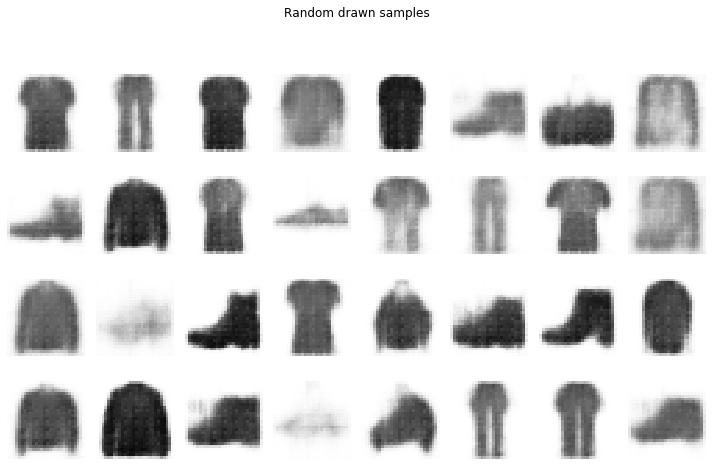

In [418]:
plt.figure(figsize=[10,6])
for i in range(32):
    latent_space = torch.normal(vmu ,vstd)
    plt.subplot(4,8,i+1)
    plt.imshow(decoder(latent_space.unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy(),cmap='Greys',vmin=0,vmax=1)
    plt.axis('off')

plt.suptitle('Random drawn samples',y=1.1)
plt.tight_layout()
plt.show()

The samples got much better than the standard autoencoder case: now most of the randomly generetad items resemble real pieces of clothing.
This is a strong inidcation that the latent space now encapsulates much more "meaningful" properties of the images and the random mapping phenomena of the standard case has been prevented.  


To further test the properties of the latent space we can plot a set of generated images obtained by varing just one latent variable at a time, while keeping the other fixed. The expiriment below accomplishes just that. By starting from a known sample, two of its latent variables are modified to obtain newly generated items, by deconding the new latent representation. It is like taking a "slice" of the latent space by fixing 8 dimensions and varing the other 2. The dimension chosen were obtained after a few rounds of trial and error, to get the most varied results.

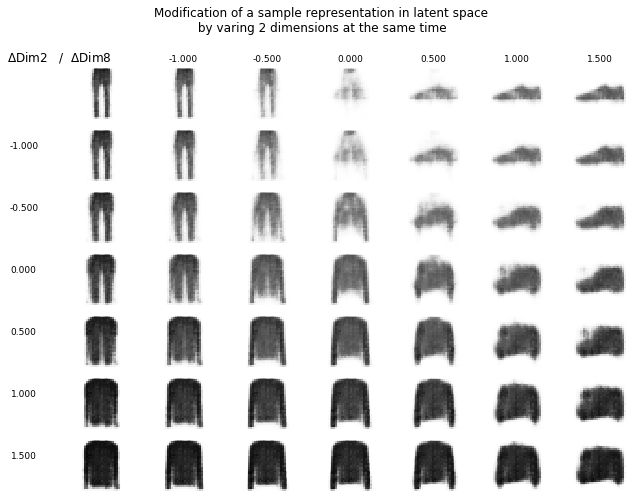

In [468]:
tot_combos  = 7
idx = 10
varencoder.eval()
decoder.eval()
plt.figure(figsize=[9,9])

dimensions = 2,8

sample1 = test_dataset[idx][0]
enc1 = varencoder(sample1.unsqueeze(0))
ps = np.linspace(-1.5,1.5,tot_combos)

with torch.no_grad():
    
    for i in range(tot_combos):
        
        for j in range(tot_combos):
            modifier = torch.zeros_like(enc1)
            modifier[0,dimensions[0]] = ps[i]
            modifier[0,dimensions[1]] = ps[j]
            
            plt.subplot(10,tot_combos,j+1+i*tot_combos)
            decod_image = decoder(enc1+modifier).squeeze(0).squeeze(0).detach()
            plt.imshow(decod_image,cmap='Greys',vmax=1,vmin=0)
            if i==0:
                plt.title(f'{ps[j]:.3f}',fontsize=9)
            if j==0:
                plt.title(f'{ps[i]:.3f}',x=-1,y=0.5,fontsize=9)
            if (i==0 and j==0):
                plt.title(f'$\Delta$Dim{dimensions[0]}   /  $\Delta$Dim{dimensions[1]}',x = -0.3 , y = 1)


            plt.axis('off')
plt.suptitle('Modification of a sample representation in latent space \n by varing 2 dimensions at the same time ',y=1.05)
plt.tight_layout()
plt.show()

The second and eigth dimension seemed to produce the most dramatic changes in the decoded images. The original decoded sample (a shirt) can be transformed in shoes and trousers by saturating the positive and negative limits of these variables. Again as we obtained with the random case, generated samples are almost always compatible with what we would expect with standard items of clothing.

# Results

In this homework an autoencoder, both standard and variational, as been succesfully implemented. A convolutional architecture has been chosen, with 3 convolutional layers, each one with doubling number of channels, and a final fully connected hidden layer before the 10 dimensional latent space output. The encoder and the decoder were chosen to have a symmetrical structure. After a random Hyperparameter search with a crovv validation setup, the newly trined network was able to reconstruct the samples in a recognizable form, but all the while losing the fine details of the items of clothing.

The standard autencoder was also able to remove white noise added to the test samples, getting them back to a human friendly form, while in the task of image reconstruction behind an occultation the network did not perform well.

The fine tuning task, where a hybrid approach was taken to accomplish a supervised learning task, did not perform well. While the network was much smaller and trained faster than their conterpart trained in the previous homework, the network perfomed a bit wrose, by mixing up a few classes very often.

By exploring the latent space with TSNE the reason why was soon clear. Items belonging to the pullover, shirt and coat class appeared really close together in this representation, meaning that the supervised learning algorithm had no way of distinguishing these samples from each other. Further exploration of the TSNE tranformation of the test set rrevealed how the other classes of clothing were clearly divided in different "islands", And some directions of the embedded space seemed to represent easly interpretable characteristics of the samples.

The artificially generated samples in the random case did not seem to have the characteristics of clothes, while the linear combination of samples seemed to have some success.

These tasks were better accomplished by the variational autoencoder. The regularization of the latent space allowed for latent variables to assume more meaningful values, so the tasks that required the generation of artificial samples were better accomplished by this architecture. 